1. IMPORTING ESSENTIAL LIBRARIES FOR THIS PROJECT

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
import numpy as np


2. LOADING TRAINING AND TEST DATASETS FROM BRAIN_TUMOR_DATASET DIRECTORY

In [2]:
path = "brain_tumor_dataset/"
training_set = tf.keras.preprocessing.image_dataset_from_directory(path,
                                             shuffle=True,
                                             batch_size=64,
                                             image_size=(160,160),
                                             validation_split=0.15,
                                             subset='training',
                                             seed=34)
test_set = tf.keras.preprocessing.image_dataset_from_directory(path,
                                             shuffle=True,
                                             batch_size=64,
                                             image_size=(160,160),
                                             validation_split=0.17,
                                             subset='validation',
                                             seed=34)



Found 253 files belonging to 2 classes.
Using 216 files for training.
Found 253 files belonging to 2 classes.
Using 43 files for validation.


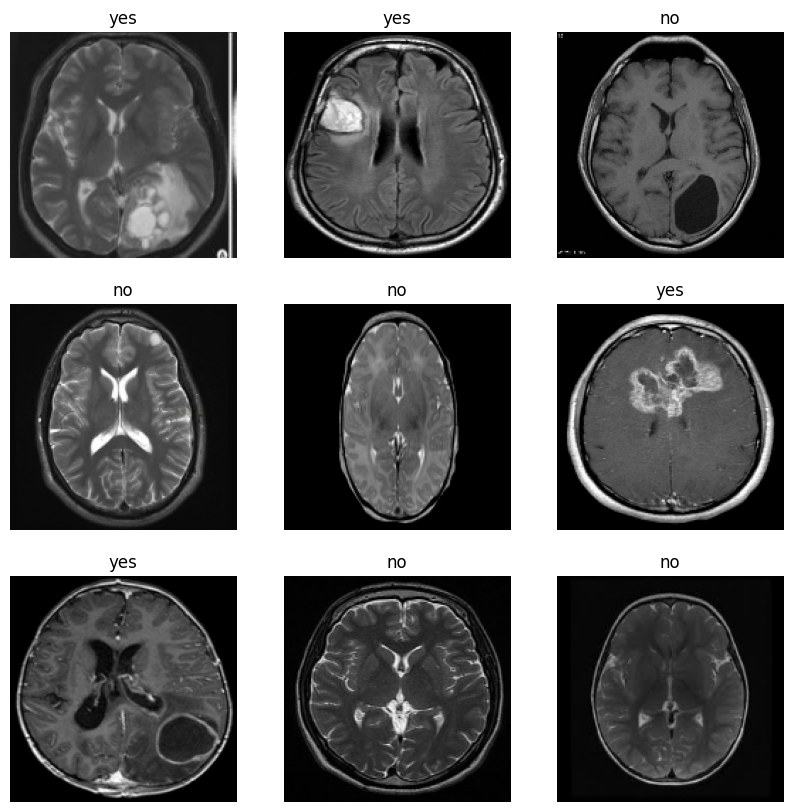

In [3]:
class_names = training_set.class_names

plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

3. DEFINING DATA AUGMENTATION AND MODEL FUNCTIONS

In [4]:
def data_augmenter():
    """ augment your data for making your data less prone to overfitting.
    :returns: data augmentation model
    """

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomFlip("vertical"))
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.34))
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomCrop(160,160))
    
    return data_augmentation

In [18]:
def tumor_identifier(image_shape=(160,160), data_augmentation=data_augmenter()):
    """ create a model for your tumor identification project. you can also use other applications of keras.
    :param image_shape: shape of the input images
    :type image_shape: tuple
    :param data
    """

    input_shape = image_shape + (3,)

    base_model = tf.keras.applications.MobileNetV3Small(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape) 
    
    x = data_augmentation(inputs) 
    x = tf.keras.applications.mobilenet_v3.preprocess_input(x)
    
    x = base_model(x, training=False) 
    
    x = tf.keras.layers.GlobalMaxPooling2D()(x) 
    x = tf.keras.layers.Dropout(0.34)(x)
        
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)
    

    return model

4. COMPILING AND SETTING METRICS

In [19]:
brain_model = tumor_identifier((160,160), data_augmenter())

brain_model.summary()

brain_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0034),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['acc'])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
MobilenetV3small (Functional (None, 1, 1, 1024)        1529968   
_________________________________________________________________
global_max_pooling2d_4 (Glob (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1025      
Total params: 1,530,993
Trainable params: 1,025
Non-trainable params: 1,529,968
_____________________________________________

5. TRAINING AND GETTING RESULTS

In [25]:
from gc import callbacks


monitor = tf.keras.callbacks.EarlyStopping(monitor='val_acc',mode='max', patience=10)

history = brain_model.fit(
        training_set,
        validation_data=test_set,
        epochs=150, 
        shuffle=True, 
        verbose=True,
        callbacks=[monitor]
        )

Epoch 1/150
4/4 [==============================] - 0s 57ms/step - loss: 0.1357 - acc: 0.9676 - val_loss: 0.2167 - val_acc: 0.8605
Epoch 2/150
4/4 [==============================] - 0s 54ms/step - loss: 0.1569 - acc: 0.9352 - val_loss: 0.2172 - val_acc: 0.8837
Epoch 3/150
4/4 [==============================] - 0s 54ms/step - loss: 0.1309 - acc: 0.9491 - val_loss: 0.2190 - val_acc: 0.8837
Epoch 4/150
4/4 [==============================] - 0s 53ms/step - loss: 0.1672 - acc: 0.9352 - val_loss: 0.2205 - val_acc: 0.8605
Epoch 5/150
4/4 [==============================] - 0s 55ms/step - loss: 0.1804 - acc: 0.9352 - val_loss: 0.2129 - val_acc: 0.8837
Epoch 6/150
4/4 [==============================] - 0s 53ms/step - loss: 0.1571 - acc: 0.9306 - val_loss: 0.2138 - val_acc: 0.8605
Epoch 7/150
4/4 [==============================] - 0s 52ms/step - loss: 0.1301 - acc: 0.9537 - val_loss: 0.2143 - val_acc: 0.8837
Epoch 8/150
4/4 [==============================] - 0s 53ms/step - loss: 0.1653 - acc: 0.91

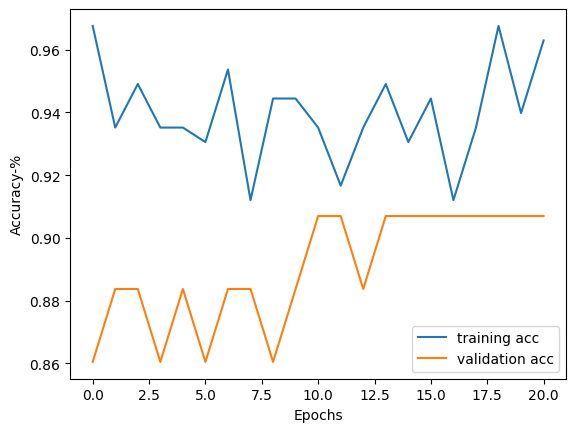

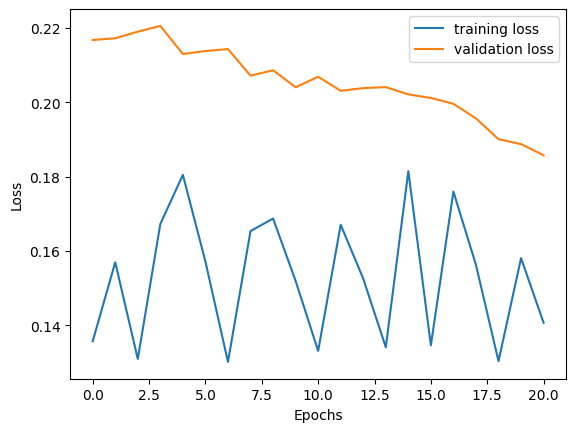

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, label='training acc')
plt.plot(epochs, val_acc, label='validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy-%')
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Brain model is performing succesfully. It has reached 95.37% accuracy on training data, and 93.02% on test data.

6. EVALUATION OF MODEL

In [27]:
train_result = brain_model.evaluate(training_set)
val_result = brain_model.evaluate(test_set)

1/1 [==============================] - 0s 63ms/step - loss: 0.1857 - acc: 0.9070


7. FINAL RESULTS: 96.76% ACCURACY ON TRAINING SET
                  93.02% ACCURACY ON TEST SET